# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [1]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [5]:
from nltk import wordpunct_tokenize
from nltk import FreqDist

## Interfax

Загрузим датасет interfax. Одновременно сделаем преобразование даты из строки

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [3]:
data_interfax = pd.read_csv('../data/interfax.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 158938: expected 17 fields, saw 20\n'
b'Skipping line 176941: expected 17 fields, saw 20\n'
b'Skipping line 280155: expected 17 fields, saw 23\n'


In [6]:
# Проверим преобразование
data_interfax.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [7]:
data_interfax.shape

(543961, 16)

In [8]:
# Так выглядет датасет interfax
data_interfax.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-04-30 13:26:00,https://www.sport-interfax.ru/659837,www.sport-interfax.ru,Спорт,NaN,Российского чемпиона мира по греко-римской бор...,Москва. 30 апреля. INTERFAX.RU - Чемпион мира ...,-,-,-,-,-,-,-,-,-
1,2019-05-07 12:46:00,https://www.sport-interfax.ru/660425,www.sport-interfax.ru,Спорт,NaN,Первый канал покажет все матчи россиян на ЧМ п...,Москва. 7 мая. INTERFAX.RU - Первый канал объя...,-,-,-,-,-,-,-,-,-
2,2019-05-08 12:57:00,https://www.sport-interfax.ru/660543,www.sport-interfax.ru,Спорт,NaN,Семак выразил надежду на новый контракт Кокори...,Москва. 8 мая. INTERFAX.RU - Главный тренер пе...,-,-,-,-,-,-,-,-,-
3,2019-05-09 00:06:00,https://www.sport-interfax.ru/660618,www.sport-interfax.ru,Спорт,NaN,"""Тоттенхэм"" стал вторым финалистом Лиги чемпионов",В финале он сыграет с другим представителем Ан...,-,-,-,-,-,-,-,-,-
4,2019-05-14 14:32:00,https://www.sport-interfax.ru/661091,www.sport-interfax.ru,Спорт,NaN,Претендовавшего на участие в ОИ скейтбордиста ...,Москва. 14 мая. INTERFAX.RU - Российский скейт...,-,-,-,-,-,-,-,-,-


In [9]:
# Выясним в каким столбцах есть пустые данные
data_interfax.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text           False
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [10]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_interfax['authors'].isnull().sum())
data_interfax[data_interfax['authors'].isnull()]

Кол-во строк с значением NaN в столбце "authors" =  521464


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-04-30 13:26:00,https://www.sport-interfax.ru/659837,www.sport-interfax.ru,Спорт,NaN,Российского чемпиона мира по греко-римской бор...,Москва. 30 апреля. INTERFAX.RU - Чемпион мира ...,-,-,-,-,-,-,-,-,-
1,2019-05-07 12:46:00,https://www.sport-interfax.ru/660425,www.sport-interfax.ru,Спорт,NaN,Первый канал покажет все матчи россиян на ЧМ п...,Москва. 7 мая. INTERFAX.RU - Первый канал объя...,-,-,-,-,-,-,-,-,-
2,2019-05-08 12:57:00,https://www.sport-interfax.ru/660543,www.sport-interfax.ru,Спорт,NaN,Семак выразил надежду на новый контракт Кокори...,Москва. 8 мая. INTERFAX.RU - Главный тренер пе...,-,-,-,-,-,-,-,-,-
3,2019-05-09 00:06:00,https://www.sport-interfax.ru/660618,www.sport-interfax.ru,Спорт,NaN,"""Тоттенхэм"" стал вторым финалистом Лиги чемпионов",В финале он сыграет с другим представителем Ан...,-,-,-,-,-,-,-,-,-
4,2019-05-14 14:32:00,https://www.sport-interfax.ru/661091,www.sport-interfax.ru,Спорт,NaN,Претендовавшего на участие в ОИ скейтбордиста ...,Москва. 14 мая. INTERFAX.RU - Российский скейт...,-,-,-,-,-,-,-,-,-
5,2019-05-22 14:06:00,https://www.sport-interfax.ru/662052,www.sport-interfax.ru,Спорт,NaN,Министр спорта призвал хоккеистов сборной Росс...,Москва. 22 мая. INTERFAX.RU - Тренерскому штаб...,-,-,-,-,-,-,-,-,-
6,2019-03-13 14:53:00,https://www.sport-interfax.ru/rfpl/654057,www.sport-interfax.ru,Спорт,NaN,"Защитник ""Спартака"" Жиго приступил к занятиям ...",Москва. 13 марта. INTERFAX.RU - Французский за...,-,-,-,-,-,-,-,-,-
7,2019-01-31 15:36:00,https://www.sport-interfax.ru/648598,www.sport-interfax.ru,Спорт,NaN,"Полузащитник ""Барселоны"" Денис Суарес перешел ...",Москва. 31 января. INTERFAX.RU - Лондонский фу...,-,-,-,-,-,-,-,-,-
8,2019-02-08 14:05:00,https://www.sport-interfax.ru/649781,www.sport-interfax.ru,Спорт,NaN,Сменился соперник чемпиона ОИ-2016 в боксе Тищ...,Москва. 8 февраля. INTERFAX.RU - Сменился сопе...,-,-,-,-,-,-,-,-,-
9,2019-02-21 15:28:00,https://www.sport-interfax.ru/651525,www.sport-interfax.ru,Спорт,NaN,МОК рассмотрит возможность включения брейк-дан...,Москва. 21 февраля. INTERFAX.RU - Оргкомитет л...,-,-,-,-,-,-,-,-,-


In [11]:
print('authors: ',data_interfax['authors'].unique())

authors:  [nan 'Анна Нехаева' 'Наталия Богданова' '/Интерфакс, Алексей Козин/'
 '/Интерфакс/' '/Интерфакс, Алиса Чудакова/' '/Анатолий Гусев, Интерфакс/'
 '/Алексей Козин, Интерфакс/' '/Интерфакс, Иван Баранов/'
 '/Интерфакс, Анатолий Гусев/' '/Иван Баранов, Интерфакс/'
 '/Карина Мелкумян, Интерфакс/' '/Алиса Чудакова, Интерфакс/'
 '/Интерфакс, Карина Мелкумян/' '/Интерфакс, Владимир Кондратьев/'
 '/Интерфакс, Дарья Карпенко/' '/Интерфакс, Зауреш Данаева/'
 '/Дарья Карпенко, Интерфакс/' '/Владимир Кондратьев, Интерфакс/'
 '/Финмаркет, Интерфакс/' '/Интерфакс, Алиса Чудакова, Анатолий Гусев/'
 '/Финмаркет/' '/Алор, Интерфакс/' '/Зауреш Данаева, Интерфакс/'
 '/Алексей Козин/' '/Интерфакс, Владимир Кондратьев, Дарья Карпенко/'
 '/Интерфакс, Дарья Карпенко, Анатолий Гусев/'
 '/Интерфакс, Владимир Кондратьев, Анатолий Гусев/' '/IFX.RU/'
 '/Финмаркет, IFX.RU/' '/Инфобизнес/' '/GlobalStock, IFX.RU/'
 '/Интерфакс, IFX.RU/' '/Интерфакс, Финмаркет/' '/Росинвестпроект/'
 '/Борис Грозовский, Дмитр

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [12]:
print('edition: ',data_interfax['edition'].unique())
print('reposts_fb: ', data_interfax['reposts_fb'].unique())
print('reposts_vk: ',data_interfax['reposts_vk'].unique())
print('reposts_ok: ',data_interfax['reposts_ok'].unique())
print('reposts_twi: ',data_interfax['reposts_twi'].unique())
print('reposts_lj: ',data_interfax['reposts_lj'].unique())
print('reposts_tg: ',data_interfax['reposts_tg'].unique())
print('likes: ',data_interfax['likes'].unique())
print('views: ',data_interfax['views'].unique())
print('comm_count: ',data_interfax['comm_count'].unique())

edition:  ['www.sport-interfax.ru' '-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


In [13]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_interfax.text.duplicated().sum())

Кол-во одинаковых текстов: 241


In [14]:
data_interfax = data_interfax.drop_duplicates(subset='text')

In [16]:
data_interfax.shape

(543720, 16)

### Анализ дат

In [17]:
print('Минимальная дата в датасете:', data_interfax.date.min())
print('Максимальная дата в датасете:', data_interfax.date.max())

Минимальная дата в датасете: 2008-02-11 03:47:00
Максимальная дата в датасете: 2019-05-27 08:09:00


#### Распределение количества новостей по месяцам

In [18]:
# Вынесем месяц и год новости в отдельные столбцы
data_interfax['month'] = data_interfax.date.apply(lambda x: x.month)
data_interfax['year'] = data_interfax.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_interfax.groupby(['year', 'month']).text.nunique().reset_index()

In [19]:
df

,year,month,text
0,2008,2,1053
1,2008,3,3263
2,2008,4,3333
3,2008,5,3142
4,2008,6,3104
5,2008,7,3536
6,2008,8,4212
7,2008,9,4708
8,2008,10,5077
9,2008,11,4480


In [20]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [21]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [22]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [23]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False)

,month_year,nunique_text
89,07-2015,5484
72,02-2014,5402
73,03-2014,5372
85,03-2015,5307
86,04-2015,5285
91,09-2015,5255
90,08-2015,5221
68,10-2013,5219
8,10-2008,5077
10,12-2008,5011


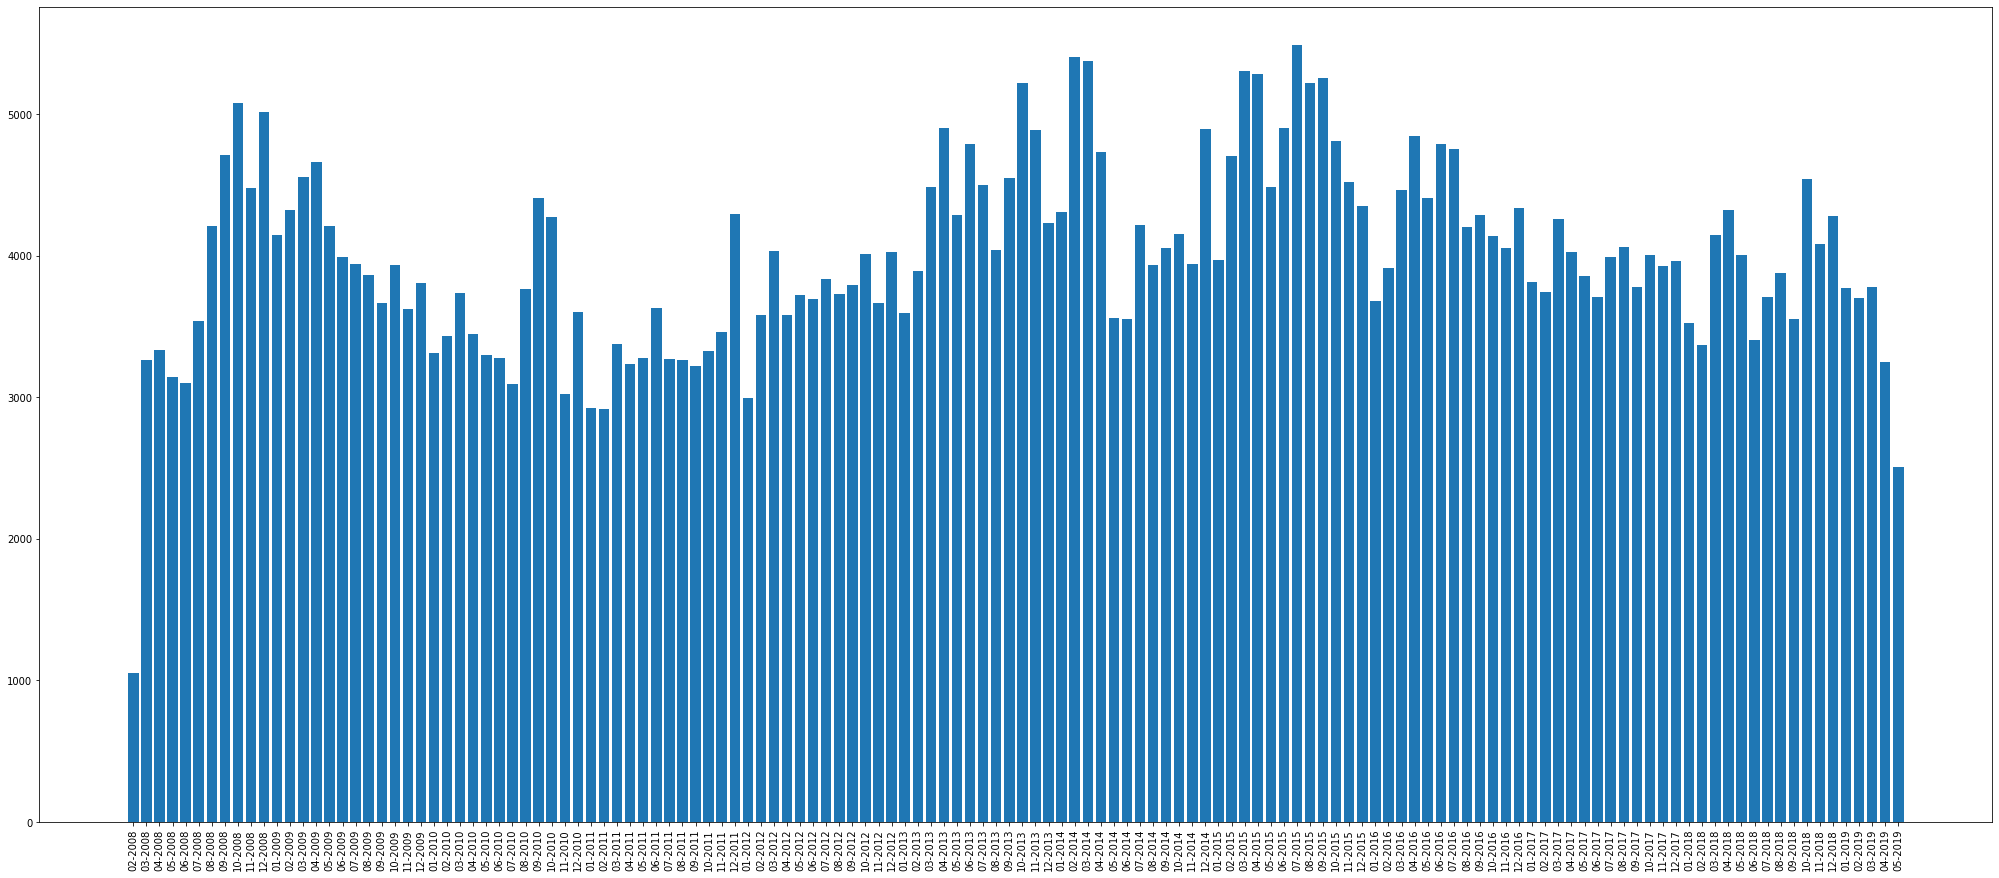

In [27]:
fig, ax = plt.subplots(figsize=(35, 15))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
# Удалим часть символов

In [29]:
import re

In [30]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\«", "", x))

In [31]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\»", "", x))

In [32]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\%", "", x))

In [33]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\,", "", x))

In [34]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\.", "", x))

In [35]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\—", "", x))

In [36]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\-", "", x))

In [37]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\:", "", x))

In [38]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\n", "", x))

In [39]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\/", "", x))

In [40]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\?", "", x))

In [41]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\)", "", x))

In [42]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\(", "", x))

In [43]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\"", "", x))

In [44]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\''", "", x))

In [45]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\'", "", x))

In [46]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\#", "", x))

In [47]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\;", "", x))

In [48]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\@", "", x))

In [49]:
data_interfax.text = data_interfax.text.apply(lambda x: re.sub("\–", "", x))

In [50]:
def text_to_token(text):
    text = text.lower()
    return wordpunct_tokenize(text)

In [51]:
def data_withoun_stopwords(text):
    text = [token for token in text if token not in stopwords]
    return text

In [52]:
dictionary_with_stopwords = FreqDist()

In [53]:
dictionary_without_stopwords = FreqDist()

In [54]:
for token in data_interfax.text.values:
    dictionary_with_stopwords.update(text_to_token(token))

In [57]:
stopwords = open('../nlp/preprocessing/stopwords.txt', 'r')
stopwords = stopwords.read().split('\n')
stopwords += ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]

In [58]:
for token in data_interfax.text.values:
    dictionary_without_stopwords.update(data_withoun_stopwords(text_to_token(token)))

In [55]:
# Посмотрим 20 самых популярных слов без удаления стопслов и построим по ним график
dictionary_with_stopwords.most_common(20)

[('в', 4598645),
 ('и', 2079046),
 ('на', 1958531),
 ('что', 1051973),
 ('по', 1034116),
 ('с', 1019828),
 ('не', 783599),
 ('interfaxru', 495743),
 ('о', 432800),
 ('из', 410577),
 ('к', 396714),
 ('москва', 376627),
 ('за', 358038),
 ('для', 326147),
 ('его', 297577),
 ('до', 289652),
 ('а', 285740),
 ('года', 282081),
 ('от', 273418),
 ('как', 257380)]

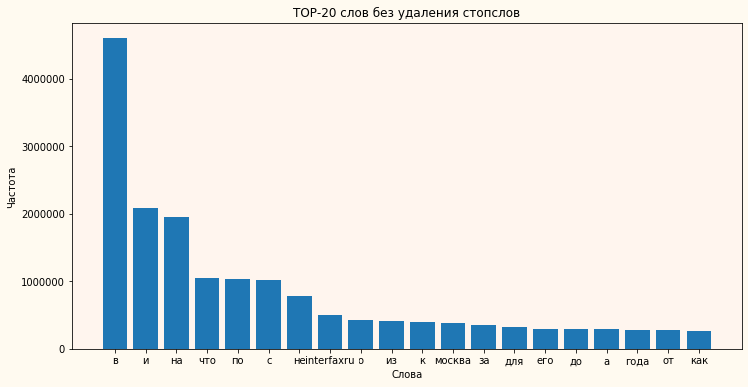

In [56]:
x = dict(dictionary_with_stopwords.most_common(20)).keys()
y = dict(dictionary_with_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

In [59]:
# Посмотрим 20 самых популярных слов после удаления стопслов и построим по ним график
dictionary_without_stopwords.most_common(20)

[('interfaxru', 495743),
 ('рф', 251861),
 ('россии', 250239),
 ('сообщил', 176121),
 ('заявил', 157137),
 ('сша', 150975),
 ('словам', 148712),
 ('интерфаксу', 146874),
 ('$', 129776),
 ('млн', 111780),
 ('млрд', 111666),
 ('отметил', 108254),
 ('данным', 105727),
 ('тыс', 101880),
 ('рублей', 101744),
 ('сообщили', 97700),
 ('1', 96775),
 ('говорится', 96323),
 ('области', 91268),
 ('марта', 85665)]

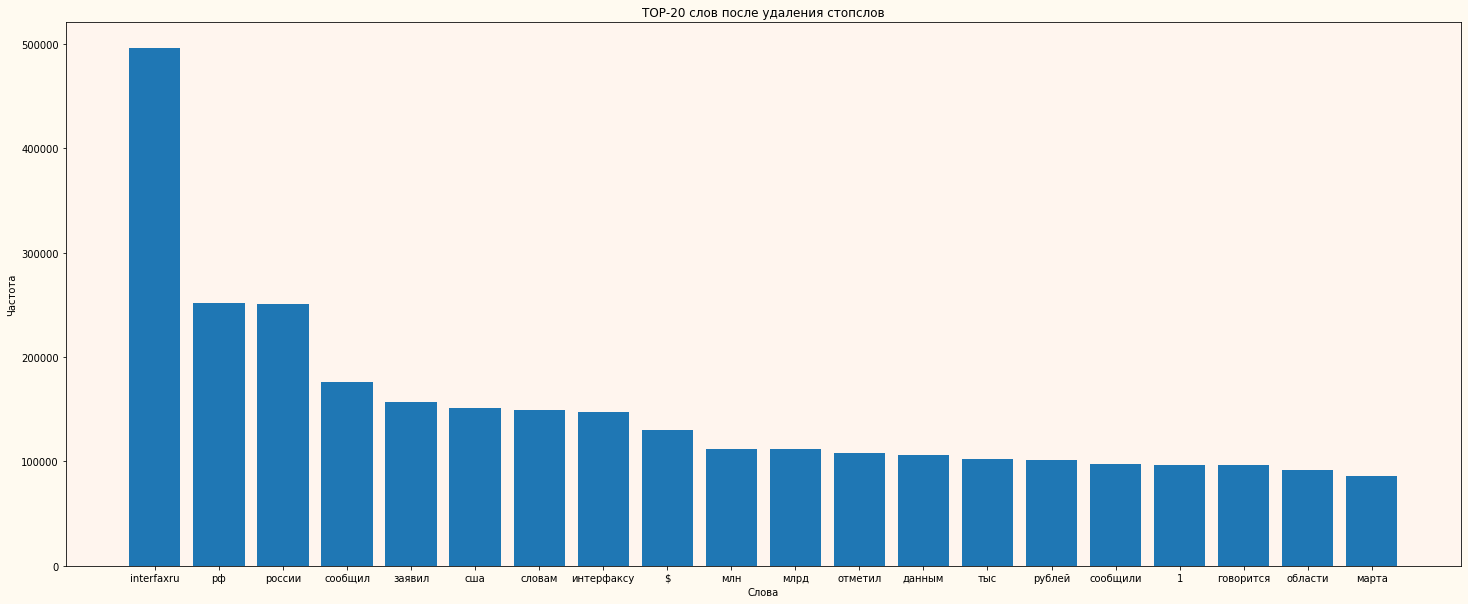

In [60]:
x = dict(dictionary_without_stopwords.most_common(20)).keys()
y = dict(dictionary_without_stopwords.most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов после удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(25)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure


plt.show()

### Рубрики interfax

In [61]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_interfax.topics.unique().shape)
data_interfax['topics'].unique()

Количество рубрик =  (8,)


array(['Спорт', 'В мире', 'В России', 'Москва', 'Экономика', 'Культура',
       'Интервью', 'Пресс-центр'], dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [62]:
data_interfax.groupby('topics')['topics'].count()

topics
В России       285983
В мире         102923
Интервью          583
Культура        12759
Москва          18415
Пресс-центр        29
Спорт           42989
Экономика       80039
Name: topics, dtype: int64